## Categorised events showcase

In [9]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage.filters import uniform_filter1d

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind
from matplotlib.ticker import FormatStrFormatter

In [10]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [11]:
warnings.filterwarnings('ignore')

In [12]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [13]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [44]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [45]:
def SCAI_index_bt(bt_sm,cri_val=240):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=cri_val,flag=2) # less than 240 K
        label_new, num_new = scai.label_remove(label_obj, N, connect_min=3) # remove obj with pixel numb. < 3
        SCAI_BT[t] = scai.SCAI_calc(label_new,num_new,dx=0.1*100000,L=5*100000)
        N_psT[t] = num_new

    return (SCAI_BT,N_psT)

In [48]:
def caseview(time_event,lat_event,lon_event):

    data_sub1 = subset_MERRA2(MERRA2_3d_dir+'TQUV_3hr'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub2 = subset_TRMM(TRMM_dir+'2009_2018'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub5 = subset_gridsat(Gridsat_dir+'2009_2018'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub6 = subset_MERRA2(MERRA2_3d_dir+'Preci_3hr'
                          ,time_event,lat_event,lon_event,2,5,5)
    
    u_sm = data_sub1.U
    v_sm = data_sub1.V
    T_sm = data_sub1.T
    q_sm = data_sub1.QV
    prec_sm = data_sub2.precipitation.resample(time='3H').nearest()
    cwv_sm = data_sub3.TQV.resample(time='3H').nearest()
    omega_sm = data_sub4.OMEGA
    bt_sm = data_sub5.irwin_cdr.resample(time='3H').nearest()
    precM2_sm = data_sub6.PRECTOT.resample(time='3H').nearest()

    u_950sm = u_sm.sel(lev=950).resample(time='3H').nearest()
    v_950sm = v_sm.sel(lev=950).resample(time='3H').nearest()
    u_tar = u_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    v_tar = v_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    omega_tar = omega_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    prec_tar = prec_sm.sel(nlon=slice(lon_event-2.5,lon_event+2.5),nlat=slice(lat_event-2.5,lat_event+2.5))
    bt_tar = bt_sm.sel(lon=slice(lon_event-2.5,lon_event+2.5),lat=slice(lat_event-2.5,lat_event+2.5))
    SCAIbt_sm, Nbt_sm = SCAI_index_bt(bt_tar,cri_val=240)  
    div_tar = np.gradient(u_tar,0.625*100*1e3,axis=3)+np.gradient(v_tar,0.5*100*1e3,axis=2) # divergence 3D
    
    p = T_sm.lev.values*units('mbar')
    T_tar = T_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    q_tar = q_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    
    # Abar calculation
    tmp = bt_tar.values
    cldfrac_sm = [len(np.where(tmp[n,:,:]<240)[0])/(tmp.shape[1]*tmp.shape[2]) for n in range(tmp.shape[0])]
    Abar_sm = cldfrac_sm/Nbt_sm*2500
    
    return (u_950sm,v_950sm,omega_sm,prec_sm,prec_tar,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm
            ,div_tar,precM2_sm)

In [17]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds_M2.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds_M2.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds_M2.dat'))

In [18]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event < lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event < lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [19]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

In [20]:
time_event = np.asarray(time_event)
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [24]:
os.chdir('/data/willytsai/ISCCP')
SCAIbt_all = np.load('SCAIbt_all_5deg_4ds_M2.mat.npy') #
cldfrac_all = np.load('cldfrac_all_5deg_4ds_M2.mat.npy') #
N_all = np.load('N_all_5deg_4ds_M2.mat.npy')
prec_all = np.load('prec_all_5deg_4ds_M2.mat.npy') #
precM2_all = np.load('precM2_all_5deg_4ds_M2.mat.npy')

In [25]:
len(time_event)

79994

In [26]:
idx_region = event_region(lat_event, lon_event, 50, 90, -10, 10)

In [27]:
time_event = time_event[idx_region]
lat_event = lat_event[idx_region]
lon_event = lon_event[idx_region]

SCAIbt_all = SCAIbt_all[idx_region,:]
cldfrac_all = cldfrac_all[idx_region,:]
prec_all = prec_all[idx_region,:]
N_all = N_all[idx_region,:]

In [28]:
idx_rm = np.arange(len(time_event))
idx_cld0 = np.where(cldfrac_all[:,16]==0)[0] # cldfrac = 0
idx_scai = np.where(np.isnan(SCAIbt_all[:,16])==1)[0] # SCAI = NaN

idx_rm = np.setdiff1d(idx_rm, idx_cld0) # remove index with all weird cases
idx_rm = np.setdiff1d(idx_rm, idx_scai) # remove index with all weird cases

In [29]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]

SCAIbt_all = SCAIbt_all[idx_rm,:]
cldfrac_all = cldfrac_all[idx_rm,:]
prec_all = prec_all[idx_rm,:]
N_all = N_all[idx_rm,:]

In [30]:
Abar_all = np.sqrt(cldfrac_all*500*500/N_all)

In [32]:
from matplotlib.backends.backend_pdf import PdfPages

In [34]:
## select categories
os.chdir('/data/willytsai/ISCCP')
idx_dec = np.load('events_idx_dec_M2RM.npy',allow_pickle=True)
tmp = idx_dec[0][0] 

In [71]:
tmp_grouped = tmp[:500].reshape(50,10)

In [72]:
with PdfPages('/data/willytsai/ISCCP/fig/event_scences_P1S1.pdf') as pdf:

    for gp in range(tmp_grouped.shape[0]):
        i = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
        j = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])
        k=0
        
        fig,ax = plt.subplots(5,4,figsize=(30,30))
        for n in range(10):

            num = tmp_grouped[gp,n]
            t = 16 # scene time at precip peak

            (u_950sm,v_950sm,omega_sm,prec_sm,prec_tar,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm,div_sm,precM2_sm) \
            = caseview(time_event[num],lat_event[num],lon_event[num])

            #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
            ax[i[k],j[k]].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
            ax[i[k],j[k]].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
            ax[i[k],j[k]].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45,50,55],colors=['w'])
            rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                                      edgecolor='r',facecolor='None')
            ax[i[k],j[k]].add_patch(rect1)
            #if n ==0:
            ax[i[k],j[k]].set_title(time_event[num])
            ax[i[k],j[k]].set_aspect('equal', adjustable='box')

            k+=1

            # right plot    
            ax[i[k],j[k]].contour(prec_sm.nlon,prec_sm.nlat,24*prec_sm[t,:,:].transpose(),
                           levels=[1,5,10,30,50],linewidths=1,colors=['m'])
            ax[i[k],j[k]].contour(precM2_sm.lon,prec_sm.lat,86400*precM2_sm[t,:,:].transpose(),
                           levels=[1,5,10,30,50],linewidths=1,colors=['orange'])            
            tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
            ax[i[k],j[k]].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
            rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                                      edgecolor='r',facecolor='None',zorder=4)
            ax[i[k],j[k]].add_patch(rect2)
            ax[i[k],j[k]].text(lon_event[num]+5.7,lat_event[num]+3.5,'N = '+str(int(N_all[num,t])),color='g',fontsize=16)
            ax[i[k],j[k]].text(lon_event[num]+5.7,lat_event[num]+2.5,'SCAI = '+str(round(SCAIbt_all[num,t],1)),color='g',fontsize=16)
            ax[i[k],j[k]].text(lon_event[num]+5.7,lat_event[num]+1.5,'Abar = '+str(round(Abar_all[num,t])),color='g',fontsize=16)
            ax[i[k],j[k]].text(lon_event[num]+5.7,lat_event[num]+0.4,r'$\rm\overline{P}$ = '+str(round(24*np.nanmean(prec_tar[t,:,:]),1)),color='g',fontsize=16)    
            ax[i[k],j[k]].set_title(time_event[num])
            ax[i[k],j[k]].set_aspect('equal', adjustable='box')
            ax[i[k],j[k]].set_xlim(lon_event[num]-5,lon_event[num]+5)

            k+=1
            #plt.tight_layout(h_pad=0.05)
        pdf.savefig(fig)
        plt.close()

In [57]:
num=1

In [58]:
(u_950sm,v_950sm,omega_sm,prec_sm,prec_tar,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm,div_sm,precM2_sm) \
            = caseview(time_event[num],lat_event[num],lon_event[num])

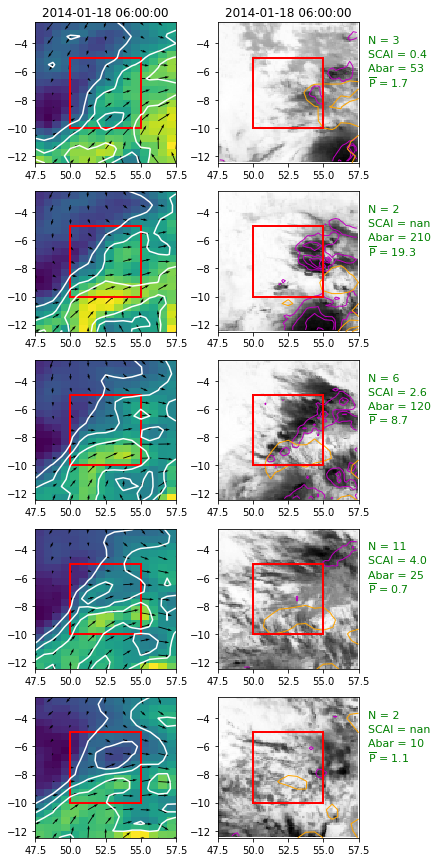

In [59]:
label = np.arange(0,7)
timelabel = np.array([12,14,16,18,20])
fig,ax = plt.subplots(len(timelabel),2,figsize=(6,15))

for n,t in zip(label,timelabel):
    #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax[n,0].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
    ax[n,0].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
    ax[n,0].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45,50,55],colors=['w'])
    rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,0].add_patch(rect1)
    if n ==0:
        ax[n,0].set_title(time_event[num])
    ax[n,0].set_aspect('equal', adjustable='box')
    
    # right plot    
    ax[n,1].contour(prec_sm.nlon,prec_sm.nlat,prec_sm[t,:,:].transpose(),
                   levels=[1,5,10,30,50],linewidths=1,colors=['m'])
    ax[n,1].contour(precM2_sm.lon,precM2_sm.lat,3600*precM2_sm[t,:,:],
                           levels=[1,5,10,30,50],linewidths=1,colors=['orange'])        
    tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
    ax[n,1].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
    rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None',zorder=4)
    ax[n,1].add_patch(rect2)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+3.5,'N = '+str(int(Nbt_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+2.5,'SCAI = '+str(round(SCAIbt_sm[t],1)),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+1.5,'Abar = '+str(round(Abar_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+0.4,r'$\rm\overline{P}$ = '+str(round(24*np.nanmean(prec_tar[t,:,:]),1)),color='g',fontsize=11)    
    if n ==0:
        ax[n,1].set_title(time_event[num])
    ax[n,1].set_aspect('equal', adjustable='box')
    ax[n,1].set_xlim(lon_event[num]-5,lon_event[num]+5)
    
#plt.tight_layout(h_pad=0.05)
#fig.savefig(fig_dir+'Aggre_showcase_P1D1_T18.pdf',bbox_inches='tight')